In [13]:
# https://www.tensorflow.org/install/source#gpu
! nvcc  --version

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = str(1)

import math
import copy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from src.utils import apply_circular_mask, cartesian_to_polar_grid, polar_transform, polar_transform_inv
from src.model import toeplitz_extractor
from src.visu import add_grad_coloring

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
Num GPUs Available:  1


In [14]:
import wandb
from datetime import datetime

dataset_name = 'cifar10'
image_size = 32
batch_size = 1024
n_epochs = 10
n_channels = 3
n_classes = 10

# see polar_transform
radius = (np.array([image_size, image_size])**2).sum()**0.5/2
len_beam = int(round(radius))
n_beams = int(round(radius*2*np.pi))
print(len_beam, n_beams)

config = {
}

wandb.init(project="RadialBeams", config=config, group='cifar10', name=datetime.now().strftime("%m%d-%H%M"))

23 142


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


equivariance test,█▅▅▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
testing loss,█▂▂▁▁
training loss,████▇▆▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
equivariance test,0.12793
testing loss,0.076
training loss,0.01055


In [15]:
train_dataset = tfds.load(dataset_name, split='train', shuffle_files=False)
test_dataset = tfds.load(dataset_name, split='test', shuffle_files=False)

def preprocess(example):
    image = tf.cast(example['image'], tf.float32) / 255.
    image = apply_circular_mask(image)
    return {
        'image': image,
        'label': example['label'],
        'polar': polar_transform(image)
    }

train_dataset = train_dataset.map(preprocess).shuffle(buffer_size=10000).batch(batch_size)
test_dataset = test_dataset.map(preprocess).batch(batch_size)

2024-02-15 07:12:50.852113: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


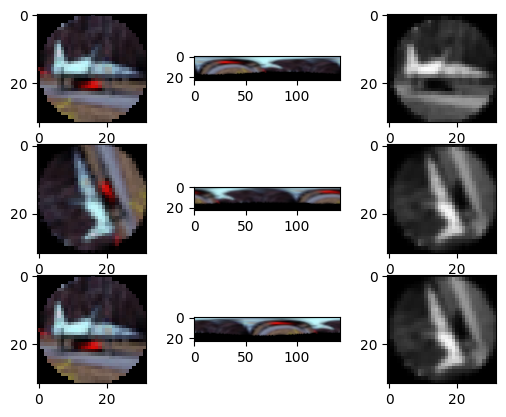

In [16]:
%matplotlib inline
fig, axs = plt.subplots(3,3)

batch_idx = 1

data = next(iter(test_dataset))
image = data['image'][batch_idx]

rot_image = tfa.image.rotate(image, 90., interpolation='bilinear')
rot_image = tf.cast(rot_image, tf.float32)

axs[0, 0].imshow(image)
axs[1, 0].imshow(rot_image)
axs[2, 0].imshow(image)

polar = data['polar'][batch_idx]
rot_polar = polar_transform(rot_image)
shifted_polar = tf.roll(polar, shift=50, axis=1)

axs[0, 1].imshow(polar)
axs[1, 1].imshow(rot_polar)
axs[2, 1].imshow(shifted_polar)

polar_inv = polar_transform_inv(polar.numpy(), output=(image_size, image_size))
rot_polar_inv = polar_transform_inv(rot_polar.numpy(), output=(image_size, image_size))
shifted_polar_inv = polar_transform_inv(shifted_polar.numpy(), output=(image_size, image_size))

axs[0, 2].imshow(polar_inv)
axs[1, 2].imshow(rot_polar_inv)
axs[2, 2].imshow(rot_polar_inv)

plt.show()

In [10]:
from tensorflow.keras import layers, models

def cyclic_beam_padding(x, padding=1):
    return tf.concat([x[:, :, x.shape[2]-padding:], x, x[:, :, :padding]], axis=-2)
    
class PolarRegressor(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # padding such that kernels of size 3 on the edges use cyclic padded values
        # padding = kernel_size - 1 using "same" padding
        self.padding = 16
        self.encoder = models.Sequential([
            layers.InputLayer(input_shape=(len_beam, n_beams+2*self.padding, n_channels)),

            layers.Conv2D(16, (3, 3), activation='gelu', padding='same'),
            layers.Conv2D(32, (3, 3), activation='gelu', padding='same'),
            layers.LayerNormalization(),
            
            layers.Conv2D(64, (3, 3), activation='gelu', padding='same'),
            layers.Conv2D(64, (3, 3), activation='gelu', padding='same'),
            layers.LayerNormalization(),

            layers.Conv2D(32, (3, 3), activation='gelu', padding='same'),
            layers.Conv2D(16, (3, 3), activation='gelu', padding='same'),
            layers.LayerNormalization(),
        ])
        self.encoder2 = models.Sequential([
            layers.InputLayer(input_shape=(n_beams, 368)),
            layers.Dense(64, activation='gelu'),
            layers.Dense(1),
            layers.Flatten()
        ])
    
    def call(self, x):
        if self.padding > 0:
            x = cyclic_beam_padding(x, padding=self.padding)
        z = self.encoder(x)
        z = tf.transpose(z, (0, 2, 1, 3))
        z = tf.reshape(z, (z.shape[0], z.shape[1], -1))
        if self.padding > 0:
            z = z[:, self.padding//2:n_beams+self.padding//2]
        z = self.encoder2(z)
        # z = tf.nn.softmax(z, axis=-1)
        return z / tf.norm(z, axis=-1, keepdims=True)

model = PolarRegressor()
model.build(input_shape=(batch_size, len_beam, n_beams, n_channels))
model.summary()
model(tf.zeros((batch_size, len_beam, n_beams, n_channels))).shape

Model: "polar_regressor_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 23, 174, 16)       83824     
                                                                 
 sequential_9 (Sequential)   (None, 142)               23681     
                                                                 
Total params: 107505 (419.94 KB)
Trainable params: 107505 (419.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


TensorShape([1024, 142])

In [11]:
def roll_batch(tensor, roll_values, axis=2):
  return tf.stack([tf.roll(tensor[i], roll_values[i], axis=axis-1) for i in range(tensor.shape[0])])

true = np.zeros((n_beams, image.shape[0]))
true[n_beams//2] = 1
true = tf.convert_to_tensor(true, dtype=tf.float32)

optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001)
for e in  tqdm(range(n_epochs)):
    # training loop
    for s, sample in enumerate(train_dataset):
        image, label = sample['polar'], sample['label']
        with tf.GradientTape() as tape:
            k_distribution = model(image)
            # cosine of hyper-unit-vectors -> normalization not needed 
            loss = 1. - (k_distribution @ true) 
            grad = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables))
        wandb.log({"training loss": np.mean(loss.numpy())}, step=e*len(train_dataset)+s)
        # equivariance test loop
        image = tf.roll(image, shift=20, axis=2) # see example above shift to right
        k_true = tf.cast(tf.fill((image.shape[0], ), 20), tf.int64)
        test_loss = tf.abs(k_true + n_beams//2-tf.argmax(model(image), axis=-1))
        wandb.log({"equivariance test": np.mean(test_loss.numpy())}, step=e*len(train_dataset)+s)
    # pseudo-equivariant test loop
    test_loss = []
    for s, sample in enumerate(test_dataset):
        image, label = sample['polar'], sample['label']
        k = tf.random.uniform(shape=(image.shape[0],), minval=-n_beams//2, maxval=n_beams//2, dtype=tf.int64)
        image = roll_batch(image, k, axis=2)
        k_distribution = model(image)
        test_loss.append(tf.abs(k + n_beams//2-tf.argmax(k_distribution, axis=-1)).numpy())
    wandb.log({"testing loss": np.concatenate(test_loss, axis=0).mean()})
    print(np.concatenate(test_loss, axis=0).mean())
# todo implement load and save of models 

  0%|                                                                                                                                                                                | 0/10 [00:00<?, ?it/s]2024-02-15 06:58:36.524163: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x23390600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-15 06:58:36.524220: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-02-15 06:58:36.528293: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-15 06:58:36.627235: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 10%|████████████████▊                                                                                                                                                       | 1/10 [01:39<14:52, 99.22s/it]

0.4746


 20%|█████████████████████████████████▌                                                                                                                                      | 2/10 [02:43<10:30, 78.82s/it]

0.1518


 30%|██████████████████████████████████████████████████▍                                                                                                                     | 3/10 [03:47<08:23, 71.90s/it]

0.1082


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 4/10 [04:52<06:54, 69.10s/it]

0.1012


 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 5/10 [05:56<05:37, 67.40s/it]

0.076


 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 5/10 [06:50<06:50, 82.18s/it]


KeyboardInterrupt: 

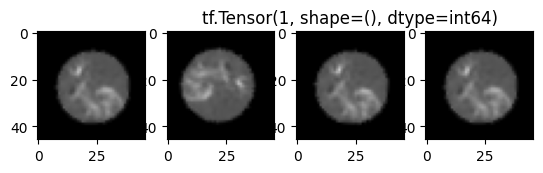

In [12]:
fig, axs = plt.subplots(1,4)
for s, sample in enumerate(train_dataset):
    image, label = sample['polar'], sample['label']
    axs[0].imshow(polar_transform_inv(image[0].numpy()))
    image = tf.roll(image, shift=50, axis=2)
    axs[1].imshow(polar_transform_inv(image[0].numpy()))
    k_distribution = model(image)
    k = tf.argmax(k_distribution, axis=-1)
    image_undo = tf.roll(image[0], shift=93+k[0], axis=1)
    axs[2].imshow(polar_transform_inv(image_undo.numpy()))
    axs[2].set_title(k[0])
    image_undo = tf.roll(image[0], shift=93-k[0], axis=1)
    axs[3].imshow(polar_transform_inv(image_undo.numpy()))
    plt.show()
    break